<a href="https://colab.research.google.com/github/falawar7/AAI614_ELAWAR/blob/main/Week7/FE_Notebook7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAI614: Data Science & its Applications

*Notebook 7.1: Introducing Dask*


Source: NVIDIA

# Dask

Dask is not faster than pandas for a single file or for small size data.  It excels for multiple data as it uses lazy computaion. In this lab, we will learn how to use Dask to speed up computation under the correct conditions.

First, let's get these libraries loaded.

In [ ]:
!git clone https://github.com/harmanani/AAI614.git /content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/data

Cloning into '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/data'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 328 (delta 141), reused 158 (delta 101), pack-reused 118 (from 1)
Receiving objects: 100% (328/328), 299.47 MiB | 9.93 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Updating files: 100% (226/226), done.


In [1]:
!git clone https://github.com/harmanani/AAI614.git /sample_data/new

Cloning into '/sample_data/new'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 328 (delta 141), reused 158 (delta 101), pack-reused 118 (from 1)
Receiving objects: 100% (328/328), 299.47 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Updating files: 100% (226/226), done.


In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.5 MB/s eta 0:00:00


In [6]:
!pip install dask

import dask.dataframe as dd
import glob
import pandas as pd
import time
import urllib
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Using Dask versus Pandas

Neither pandas or cuDF can read in multiple CSV files directly with [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). In order to read multiple files into a DataFrame, we would need to loop through each file and append them together.

To see this, let's pull a couple more files from the [Water Level Website](https://tidesandcurrents.noaa.gov/stations.html?type=Water+Levels). This time, we will request a CSV and save it with the [urllib.request](https://docs.python.org/3/library/urllib.request.html).

We should now have a few `.csv` files in the `data` folder. When referencing these files, we could type out the paths of each of these files individually, but instead, we will use the [glob](https://docs.python.org/3/library/glob.html) library to programmatically do this for us. We can use `*` as a wild card to filter files that match our pattern specified like so:

In [ ]:
file_paths = glob.glob('/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/*.csv')
file_paths = [file for file in file_paths if file != 'data/numbers.csv']
file_paths

['/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00024534.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00027876.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00030220.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00010957.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00014209.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00024586.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00015553.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00012124.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00010140.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00013043.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week7/Data/USC00012675.csv',
 '/content

Each path starts with `data`, ends with `.csv`, and the `*` indicates to pick up anything in between. Let's set up a for loop to see how long it takes to read all of these files. Run the block **twice** to see how much faster cuDF is after it has been initialized.

In [6]:
usecols = [0, 1, 2, 4, 5]  # Column names are different when pulling csv directly


def read_all(library, file_paths):
    df_list = []
    for file in file_paths:
        df = library.read_csv(
            file, index_col=None, header=None, usecols=usecols, skiprows=1
        )
        df_list.append(df)
    return library.concat(df_list, axis=0, ignore_index=True)



df_cpu = read_all(pd, file_paths)

In [7]:
df_cpu

,0,1,2,4,5
0,USC00010957,34.2008,-86.1633,1948-06-01,HPCP
1,USC00010957,34.2008,-86.1633,1948-06-02,HPCP
2,USC00010957,34.2008,-86.1633,1948-06-03,HPCP
3,USC00010957,34.2008,-86.1633,1948-06-04,HPCP
4,USC00010957,34.2008,-86.1633,1948-06-05,HPCP
...,...,...,...,...,...
1013567,USC00021749,34.0500,-110.4500,2020-10-17,HPCP
1013568,USC00021749,34.0500,-110.4500,2020-10-18,HPCP
1013569,USC00021749,34.0500,-110.4500,2020-10-19,HPCP
1013570,USC00021749,34.0500,-110.4500,2020-10-20,HPCP


Since Dask is made to be parallel, we do not need a for loop. It can read multiple files natively.

The below code shows how to read data in parallel. This only sets up the process to read the files. we need to force Dask to *compute*

In [8]:
ddf_cpu = dd.read_csv(file_paths, usecols=usecols, header=0, skipinitialspace=True)

ddf_cpu.compute()

,STATION,LATITUDE,LONGITUDE,DATE,ELEMENT
0,USC00010957,34.2008,-86.1633,1948-06-01,HPCP
1,USC00010957,34.2008,-86.1633,1948-06-02,HPCP
2,USC00010957,34.2008,-86.1633,1948-06-03,HPCP
3,USC00010957,34.2008,-86.1633,1948-06-04,HPCP
4,USC00010957,34.2008,-86.1633,1948-06-05,HPCP
...,...,...,...,...,...
10269,USC00021749,34.0500,-110.4500,2020-10-17,HPCP
10270,USC00021749,34.0500,-110.4500,2020-10-18,HPCP
10271,USC00021749,34.0500,-110.4500,2020-10-19,HPCP
10272,USC00021749,34.0500,-110.4500,2020-10-20,HPCP


Let's sample our data to confirm it had been read correctly. This time, we will only be working with the first three columns of data.

In [9]:
%%time
ddf_cpu.head()

CPU times: user 86.8 ms, sys: 13.6 ms, total: 100 ms
Wall time: 101 ms


,STATION,LATITUDE,LONGITUDE,DATE,ELEMENT
0,USC00010957,34.2008,-86.1633,1948-06-01,HPCP
1,USC00010957,34.2008,-86.1633,1948-06-02,HPCP
2,USC00010957,34.2008,-86.1633,1948-06-03,HPCP
3,USC00010957,34.2008,-86.1633,1948-06-04,HPCP
4,USC00010957,34.2008,-86.1633,1948-06-05,HPCP


How can Dask do this faster than regular pandas or cuDF? Under the hood, Dask is building a system of operations called a DAG. We can view this DAG with the [visualize](https://docs.dask.org/en/latest/graphviz.html) method.

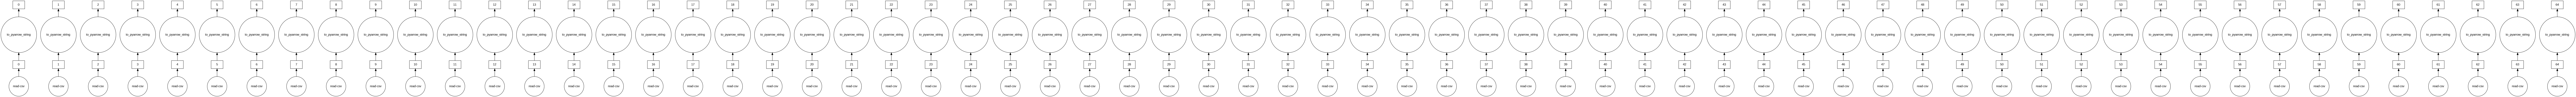

In [10]:
ddf_cpu.visualize()

# **Visualize the low level graph**

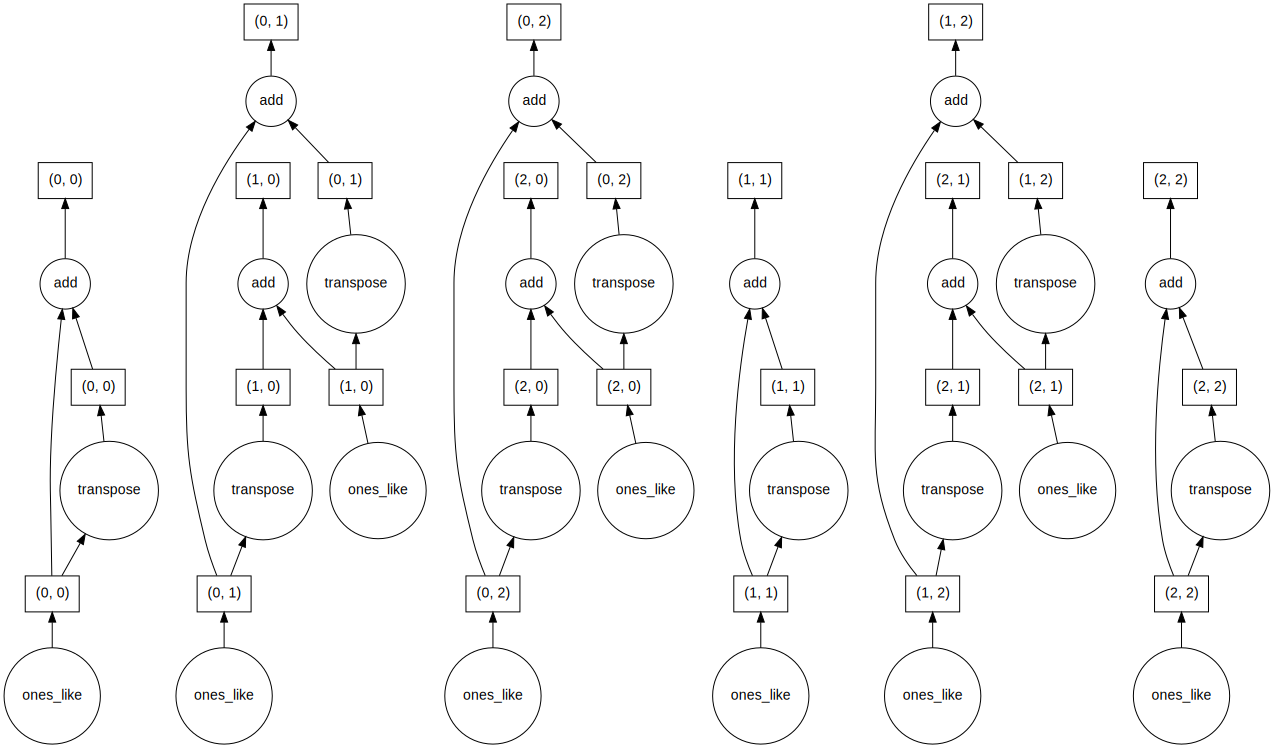

In [11]:
import dask.array as da
x = da.ones((15, 15), chunks=(5, 5))

y = x + x.T

y.compute()

# visualize the low level Dask graph
y.visualize(filename='transpose.svg')

# **optimize The graph**

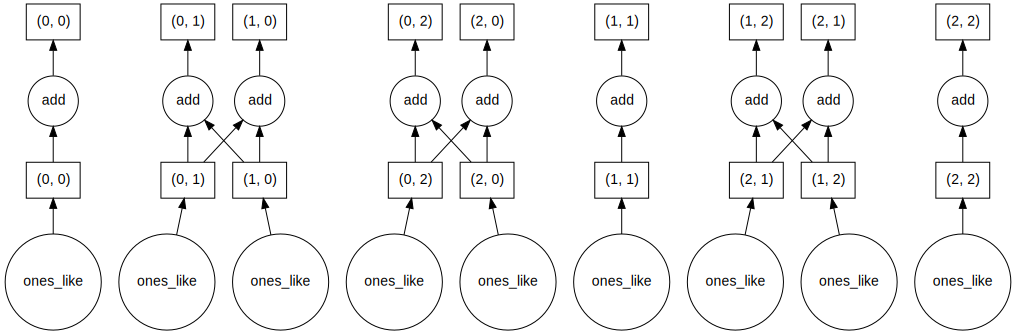

In [12]:
import dask.array as da
x = da.ones((15, 15), chunks=(5, 5))

y = x + x.T

# visualize the low level Dask graph after optimizations
y.visualize(filename="transpose_opt.svg", optimize_graph=True)

In [14]:
!pip install ipycytoscape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.0 MB/s eta 0:00:00


# **Visualization with cytoscape**

In [17]:
import dask.array as da
import dask
x = da.ones((15, 15), chunks=(5, 5))

y = x + x.T

# visualize the low level Dask graph using cytoscape
y.visualize(engine="cytoscape")

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

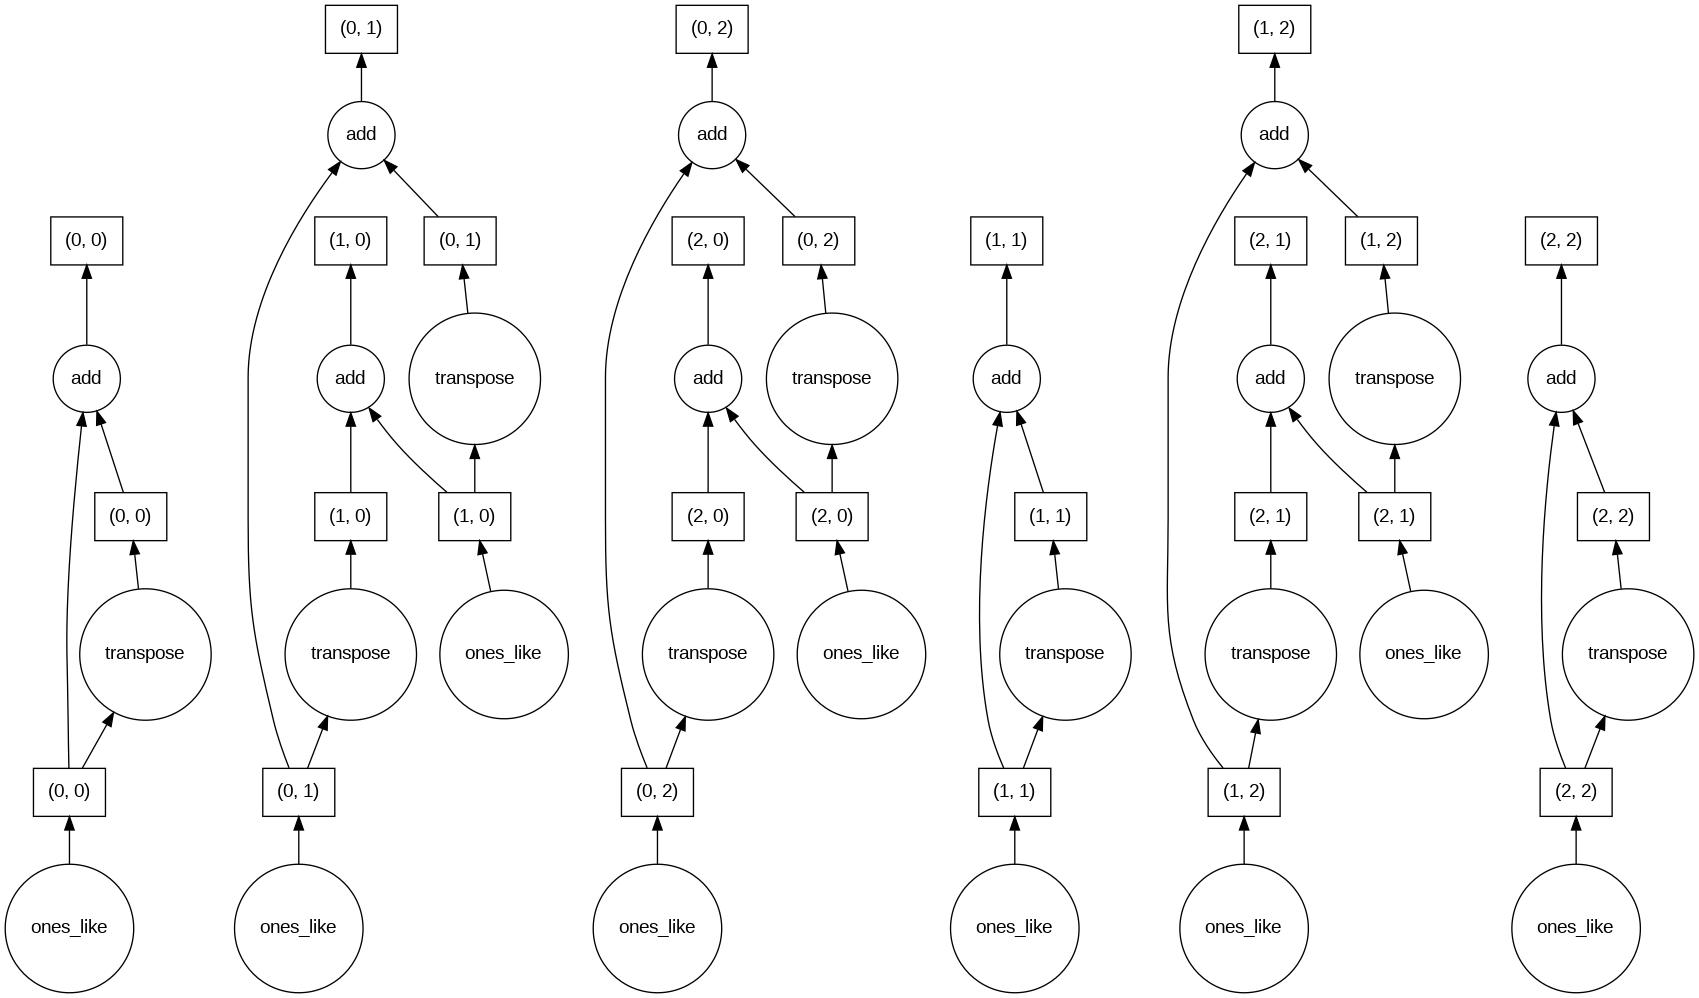

In [23]:
y.visualize()

In [25]:
import dask.array as da
x = da.ones((15, 15), chunks=(5, 5))

y = x + x.T

with dask.config.set({"visualization.engine": "cytoscape"}):
  y.visualize()

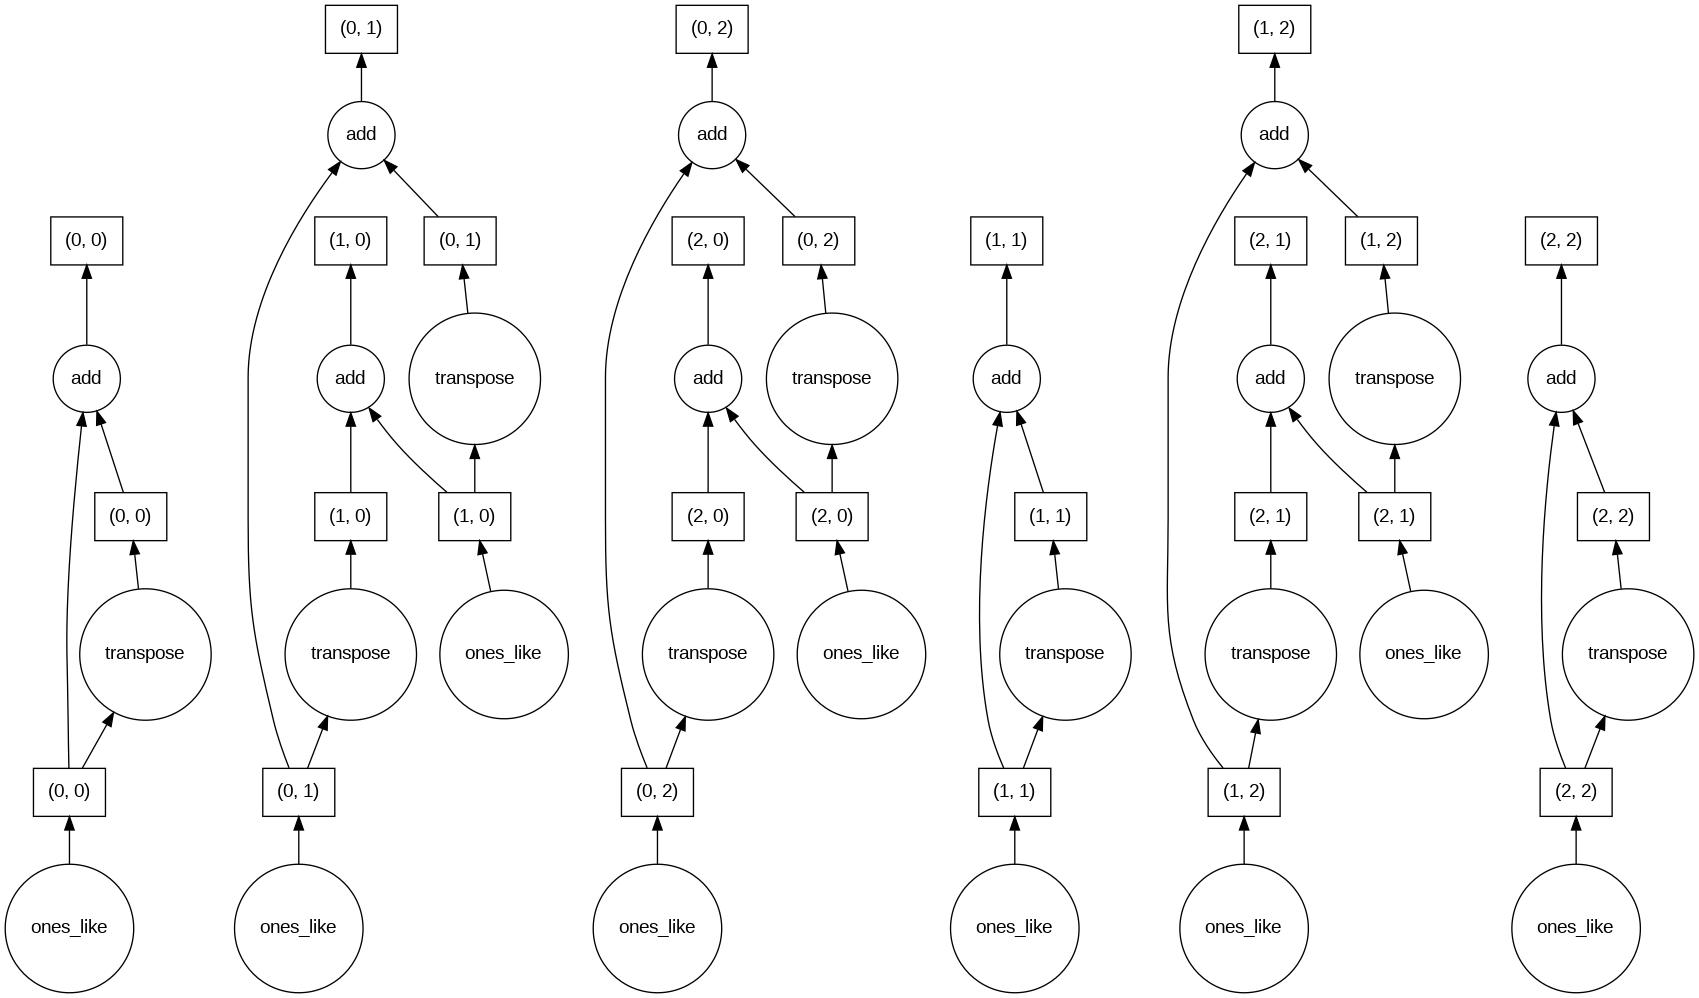

In [26]:
y.visualize()

# **Visualize the high level graph**

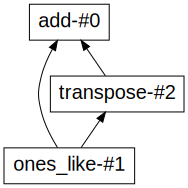

In [21]:
import dask.array as da
x = da.ones((15, 15), chunks=(5, 5))
y = x + x.T

# visualize the high level Dask graph
y.dask.visualize(filename='transpose-hlg.svg')

# **High level graph HTML representation**

In [22]:
import dask.array as da
x = da.ones((15, 15), chunks=(5, 5))
y = x + x.T

y.dask  # shows the HTML representation in a Jupyter notebook

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7d9cfc1a5960>
 0. ones_like-8ca8763e77687b00c92f707738d5e022
 1. transpose-67b3da0122d4a0f8bda12dbd0df77245
 2. add-1cfea399d91e2b2ef55b4b5618805cb3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Checking with NYC Taxi Dataset**

In [7]:
file_paths = glob.glob('/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/*.csv')
file_paths = [file for file in file_paths if file != 'data/numbers.csv']
file_paths

['/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01ab.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01aa.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01ac.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01ad.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01ae.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01af.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01ai.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01ah.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-01ag.csv',
 '/content/drive/Othercomputers/THINKPAD-T14/AI/Data_Science/Week2/nyc_taxi/nyc_taxi_2019-0

In [24]:
usecols = [0, 1, 3, 4, 5,7,8,9]  # Column names are different when pulling csv directly


def read_all(library, file_paths):
    df_list = []
    for file in file_paths:
        df = library.read_csv(
            file, index_col=None, header=None, usecols=usecols, skiprows=1
        )
        df_list.append(df)
    return library.concat(df_list, axis=0, ignore_index=True)



df_cpu = read_all(pd, file_paths)

In [25]:
df_cpu

,0,1,3,4,5,7,8,9
0,1.0,2019-01-02 10:50:25,1.0,8.60,1.0,138.0,107.0,1.0
1,2.0,2019-01-02 10:41:24,6.0,14.23,1.0,138.0,50.0,1.0
2,2.0,2019-01-02 10:43:39,1.0,1.21,1.0,262.0,140.0,2.0
3,1.0,2019-01-02 10:26:51,1.0,0.50,1.0,237.0,141.0,2.0
4,1.0,2019-01-02 10:52:14,1.0,0.80,1.0,161.0,229.0,2.0
...,...,...,...,...,...,...,...,...
13978205,NaN,2019-07-29 16:34:53,NaN,3.86,NaN,137.0,7.0,NaN
13978206,NaN,2019-07-29 16:07:57,NaN,15.48,NaN,162.0,81.0,NaN
13978207,NaN,2019-07-29 16:01:31,NaN,12.92,NaN,70.0,89.0,NaN
13978208,NaN,2019-07-29 16:58:00,NaN,7.12,NaN,209.0,71.0,NaN


In [27]:
ddf_cpu = dd.read_csv(file_paths, usecols=usecols, header=0, skipinitialspace=True, dtype={'1': 'float64', '43': 'float64'}) # Specify dtype for columns '1' and '4

In [28]:
%%time
ddf_cpu.head()

CPU times: user 1.42 s, sys: 57 ms, total: 1.47 s
Wall time: 1.55 s


43    1  \
1 2019-01-02 10:50:25 2019-01-02 11:23:04 1.0 8.60  1.0 N 138.0  107.0  1.0   
2 2019-01-02 10:41:24 2019-01-02 11:41:39 6.0 14.23 1.0 N 138.0   50.0  1.0   
  2019-01-02 10:43:39 2019-01-02 10:51:02 1.0 1.21  1.0 N 262.0  140.0  2.0   
1 2019-01-02 10:26:51 2019-01-02 10:31:44 1.0 0.50  1.0 N 237.0  141.0  2.0   
  2019-01-02 10:52:14 2019-01-02 11:00:50 1.0 0.80  1.0 N 161.0  229.0  2.0   

                                                                    0   0.5  \
1 2019-01-02 10:50:25 2019-01-02 11:23:04 1.0 8.60  1.0 N 138.0  <NA>  <NA>   
2 2019-01-02 10:41:24 2019-01-02 11:41:39 6.0 14.23 1.0 N 138.0  <NA>  <NA>   
  2019-01-02 10:43:39 2019-01-02 10:51:02 1.0 1.21  1.0 N 262.0  <NA>  <NA>   
1 2019-01-02 10:26:51 2019-01-02 10:31:44 1.0 0.50  1.0 N 237.0  <NA>  <NA>   
  2019-01-02 10:52:14 2019-01-02 11:00:50 1.0 0.80  1.0 N 161.0  <NA>  <NA>   

                                                                 2.76   0.3  \
1 2019-01-02 10:50:25 2019-01-02 11:23:04 1.0 8.60  1.0 N 138.0  <NA>  <NA>   
2 2019-01-02 10:41:24 2019-01-02 11:41:39 6.0 14.23 1.0 N 138.0  <NA>  <NA>   
  2019-01-02 10:43:39 2019-01-02 10:51:02 1.0 1.21  1.0 N 262.0  <NA>  <NA>   
1 2019-01-02 10:26:51 2019-01-02 10:31:44 1.0 0.50  1.0 N 237.0  <NA>  <NA>   
  2019-01-02 10:52:14 2019-01-02 11:00:50 1.0 0.80  1.0 N 161.0  <NA>  <NA>   

                                                                16.56  \
1 2019-01-02 10:50:25 2019-01-02 11:23:04 1.0 8.60  1.0 N 138.0  <NA>   
2 2019-01-02 10:41:24 2019-01-02 11:41:39 6.0 14.23 1.0 N 138.0  <NA>   
  2019-01-02 10:43:39 2019-01-02 10:51:02 1.0 1.21  1.0 N 262.0  <NA>   
1 2019-01-02 10:26:51 2019-01-02 10:31:44 1.0 0.50  1.0 N 237.0  <NA>   
  2019-01-02 10:52:14 2019-01-02 11:00:50 1.0 0.80  1.0 N 161.0  <NA>   

                                                                Unnamed: 9  
1 2019-01-02 10:50:25 2019-01-02 11:23:04 1.0 8.60  1.0 N 138.0       <NA>  
2 2019-01-02 10:41:24 2019-01-02 11:41:39 6.0 14.23 1.0 N 138.0       <NA>  
  2019-01-02 10:43:39 2019-01-02 10:51:02 1.0 1.21  1.0 N 262.0       <NA>  
1 2019-01-02 10:26:51 2019-01-02 10:31:44 1.0 0.50  1.0 N 237.0       <NA>  
  2019-01-02 10:52:14 2019-01-02 11:00:50 1.0 0.80  1.0 N 161.0       <NA>

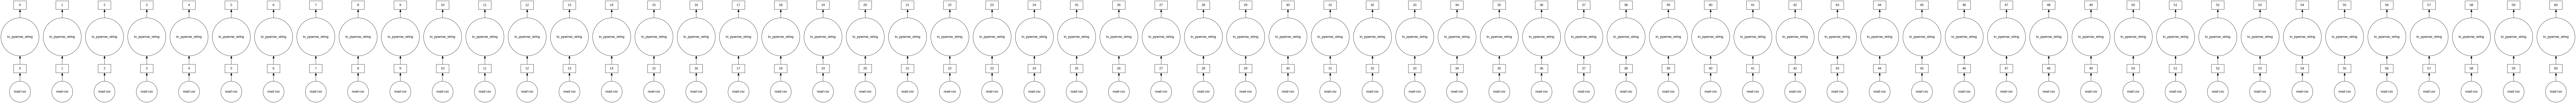

In [29]:
ddf_cpu.visualize()

# **Visualize the low level graph**

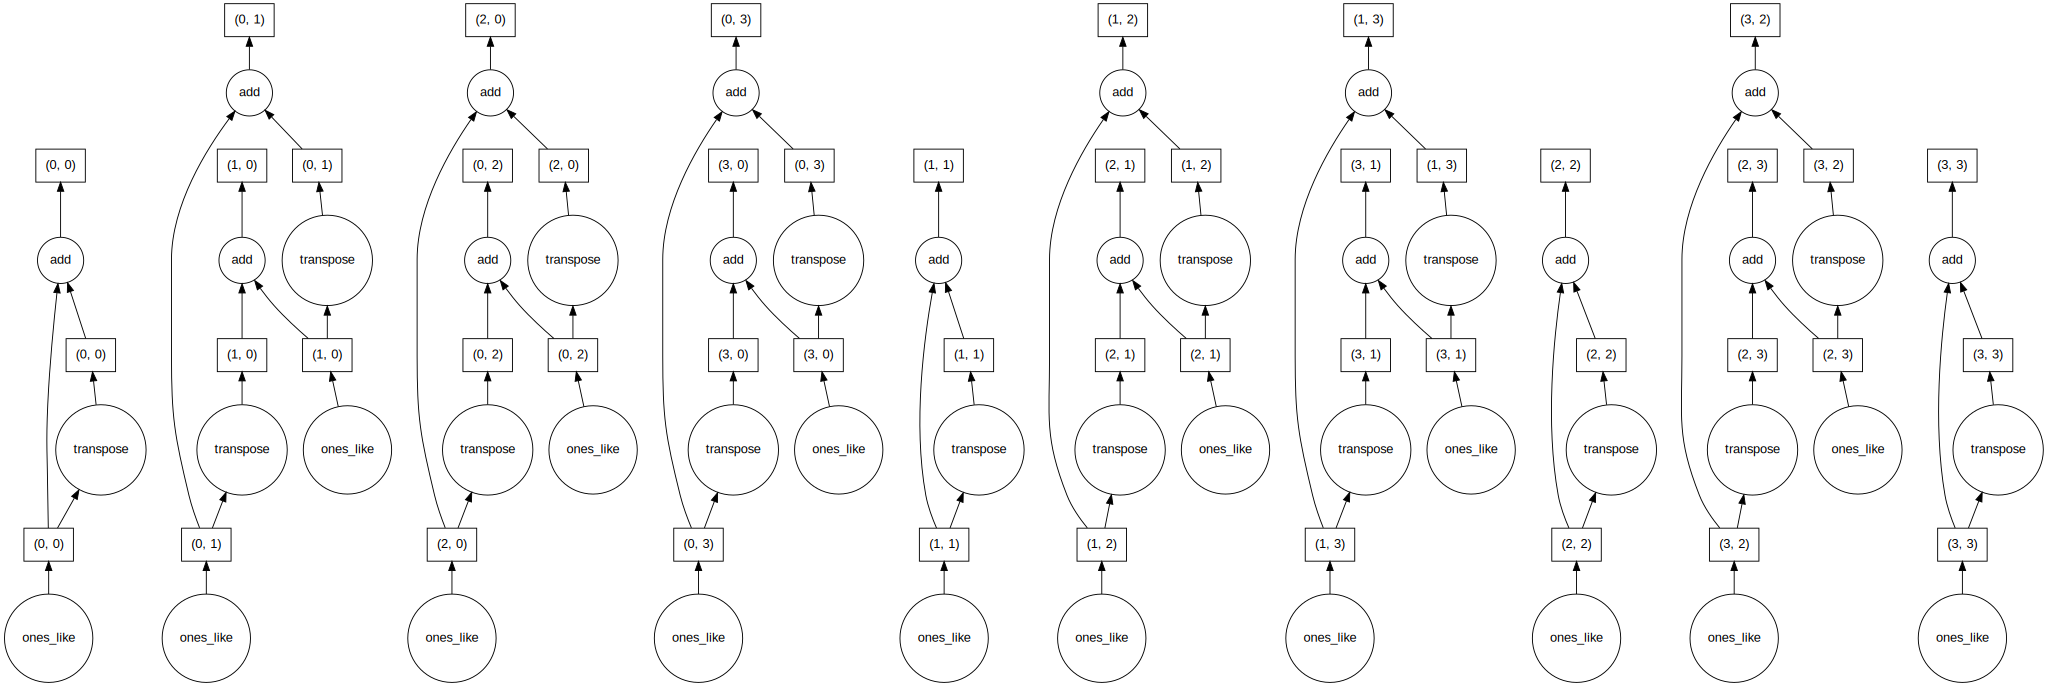

In [51]:
import dask.array as da
x = da.ones((20, 20), chunks=(5, 5))

y = x + x.T

y.compute()

# visualize the low level Dask graph
y.visualize(filename='transpose2.svg')

# **optimize The graph**

# **Visualization with cytoscape**

In [52]:
import dask.array as da
import dask
x = da.ones((20, 20), chunks=(5, 5))

y = x + x.T

# visualize the low level Dask graph using cytoscape
y.visualize(engine="cytoscape")

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

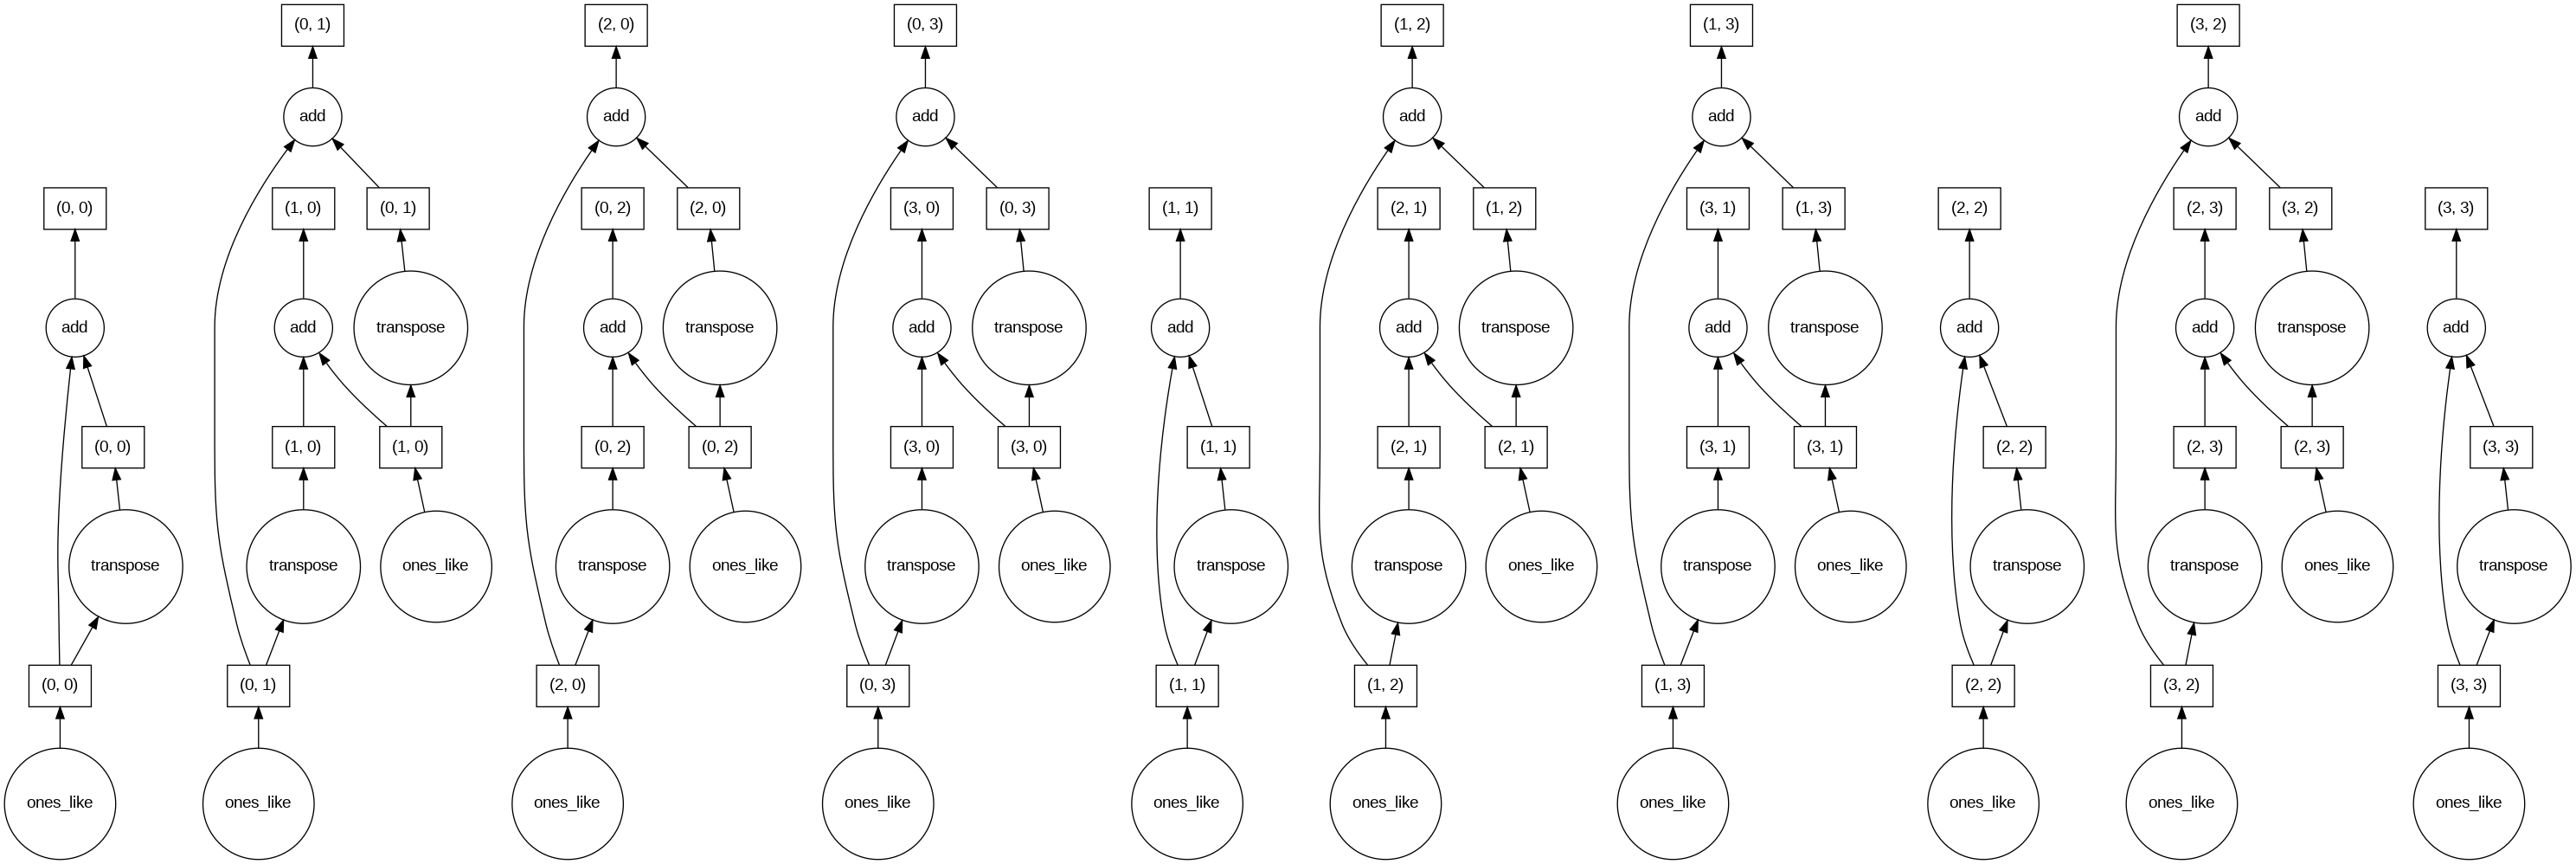

In [53]:
y.visualize()

In [54]:
import dask.array as da
x = da.ones((20, 20), chunks=(5, 5))
y = x + x.T

with dask.config.set({"visualization.engine": "cytoscape"}):
  y.visualize()

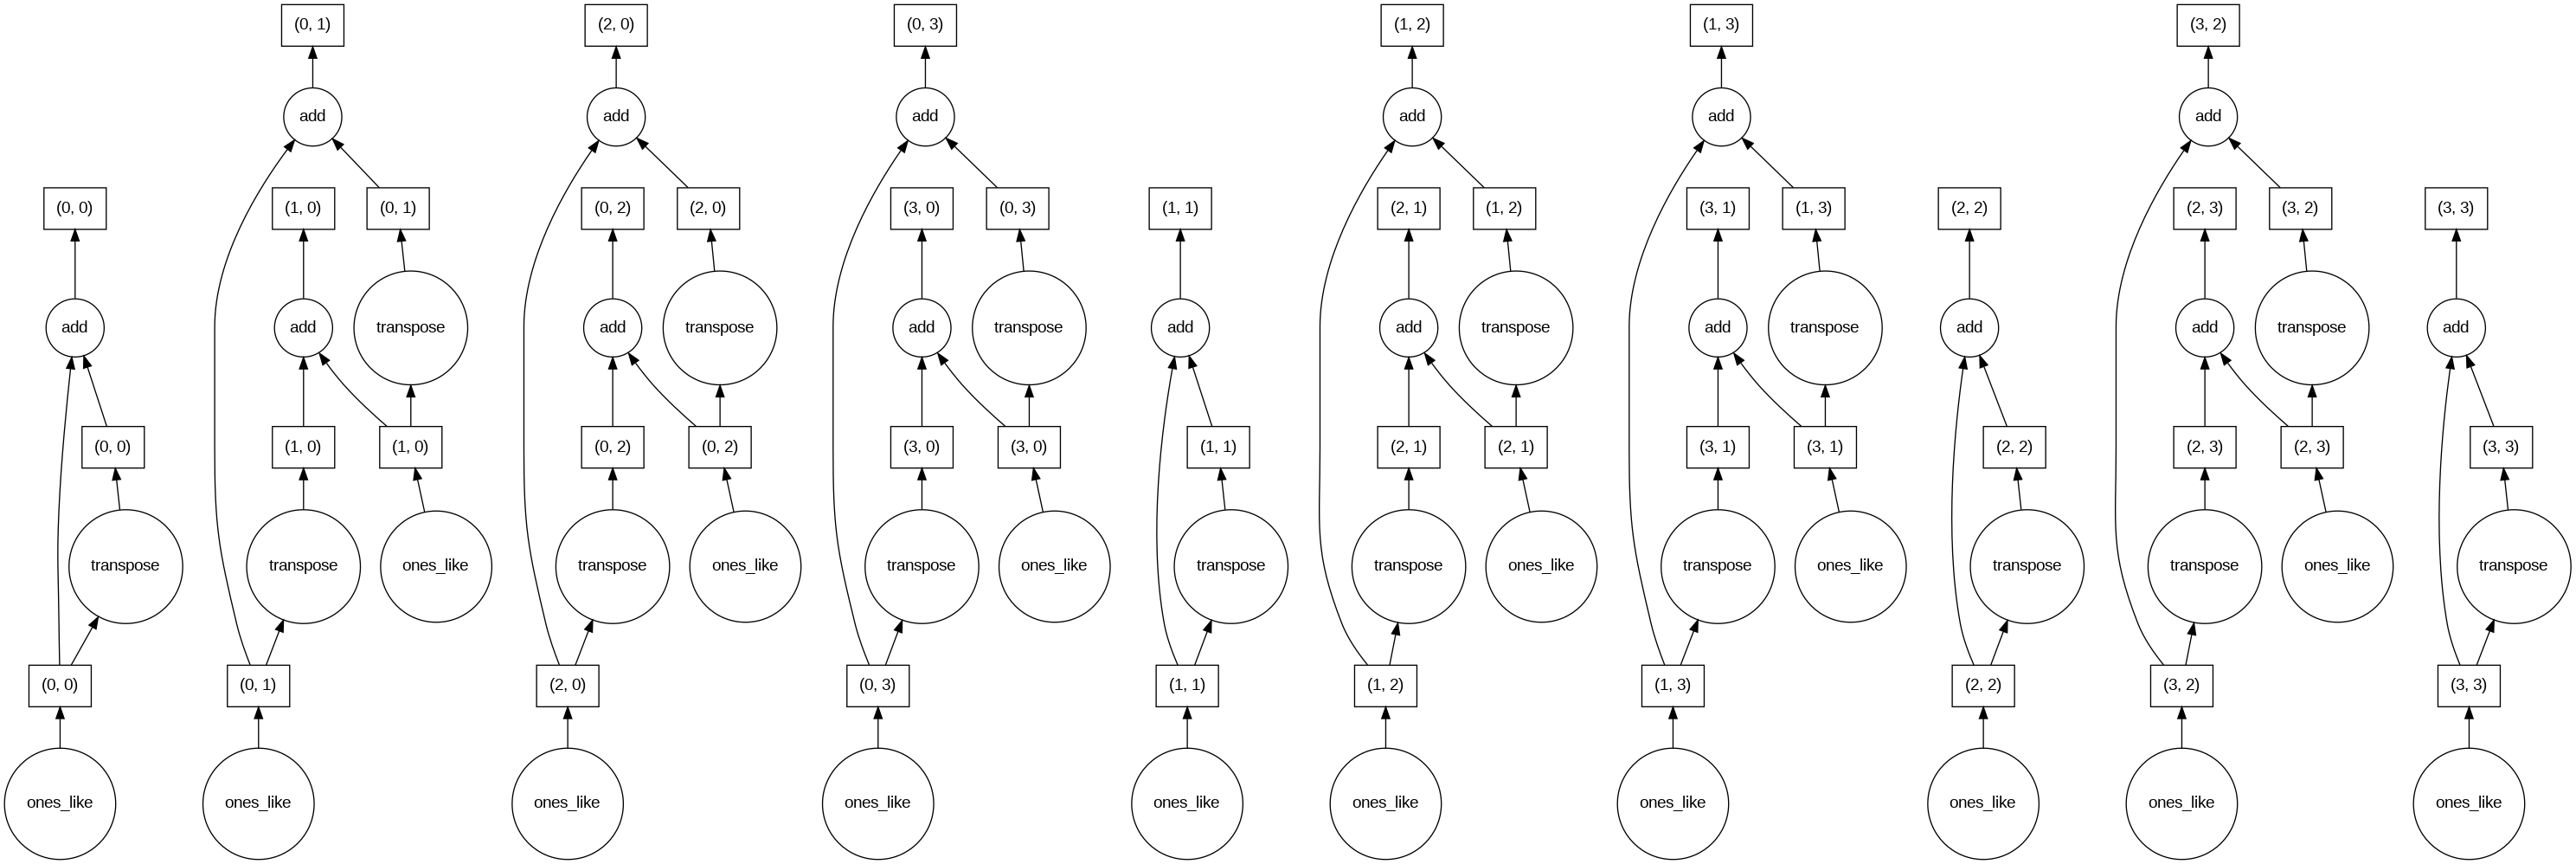

In [55]:
y.visualize()

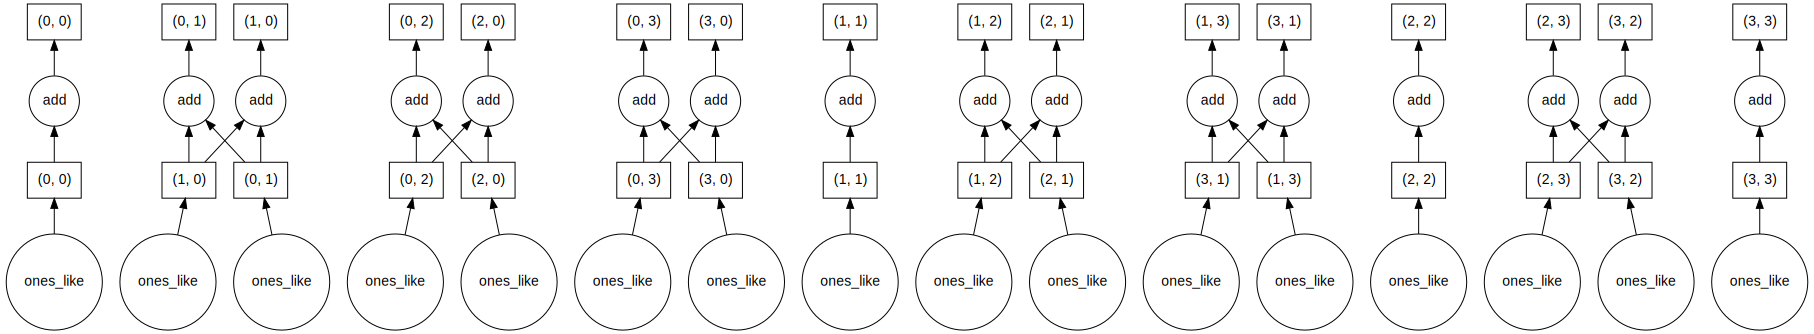

In [46]:
import dask.array as da
x = da.ones((20, 20), chunks=(5, 5))

y = x + x.T

# visualize the low level Dask graph after optimizations
y.visualize(filename="transpose_opt.svg", optimize_graph=True)

# **Visualize the high level graph**

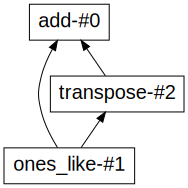

In [45]:
import dask.array as da
x = da.ones((20, 20), chunks=(5, 5))
y = x + x.T

# visualize the high level Dask graph
y.dask.visualize(filename='transpose-hlg.svg')

# **High level graph HTML representation**

In [43]:
import dask.array as da
x = da.ones((20, 20), chunks=(5, 5))
y = x + x.T

y.dask  # shows the HTML representation in a Jupyter notebook

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7b36a8407340>
 0. ones_like-496fb20deabb4e081c6e628de8b2af53
 1. transpose-20b3303a3b4aa23ab641effd4996d063
 2. add-c44d5f014d4ce0a46acb7d76097692b1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
!pip install ipycytoscape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.3 MB/s eta 0:00:00
